In [0]:
'''
Custom Logging
Running Logging notebook in next command

Log file is shown in the last command
'''

Out[45]: '\nCustom Logging\nRunning Logging notebook in next command\n'

In [0]:
%run ./Logging

In [0]:
logger.info('=========Start INFO Logger Here ========')
logger.debug('=========Start DEBUG Logger Here ========')
logger.error('=========Start ERROR Logger Here ========')
logger.warning('=========Start Warning Logger Here ========')
logger.critical('=========Start Critical Logger Here ========')

2022-02-11 06:52:34,495 - custom_log - INFO - =========Start INFO Logger Here ========
2022-02-11 06:52:34,498 - custom_log - DEBUG - =========Start DEBUG Logger Here ========
2022-02-11 06:52:34,500 - custom_log - ERROR - =========Start ERROR Logger Here ========
2022-02-11 06:52:34,502 - custom_log - WARNING - =========Start Warning Logger Here ========
2022-02-11 06:52:34,505 - custom_log - CRITICAL - =========Start Critical Logger Here ========


In [0]:
'''
Spark Mode YARN
'''

try:
    from pyspark.sql.functions import *
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import regexp_replace, col
    from pyspark.sql.types import IntegerType, FloatType
    spark = SparkSession.builder.master('yarn').appName('E-Commerce').getOrCreate()
except ImportError as ex:
    logger.error(ex)

In [0]:
'''
Spark Configuration (Memory Config) with local mode with 3 executors og 500mb each and driver memory of 1 gb
'''
#pyspark --master local[2] --driver-memory 1g --executor-memory 500m --executor-cores 2 --num-executors 3

Out[50]: '\nSpark Configuration (Memory Config) with local mode with 3 executors og 500mb each and driver memory of 1 gb\n'

/tmp/custom_log2022-02-11 12-22-34.log


In [0]:
'''
Creating a single function to load all files to dataframes 
'''

try:
    def loadFile(fileName, path):
        df = spark.read.format("csv").option("header", "true").load(path)
        return df
except FileNotFoundError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

In [0]:
'''
Perform ETL operations
'''
msg = 'Successfully loaded the files into Storage'

try:
    customers_filePath = 'dbfs:/FileStore/shared_uploads/yoganshu.raikhere2@mindtree.com/olist_customers_dataset.csv'
    customers_df = loadFile('olist_customers_dataset.csv', customers_filePath)
    
    geolocation_filePath = "dbfs:/FileStore/shared_uploads/yoganshu.raikhere2@mindtree.com/olist_geolocation_dataset.csv"
    geolocation_df = loadFile('olist_geolocation_dataset.csv', geolocation_filePath)
    geolocation_df = geolocation_df.withColumn("geolocation_city", regexp_replace(col("geolocation_city"), "[^a-z A-Z]", ""))

    order_items_filePath = "dbfs:/FileStore/shared_uploads/yoganshu.raikhere2@mindtree.com/olist_order_items_dataset.csv"
    order_items_df = loadFile('olist_order_items_dataset.csv', order_items_filePath)
    order_items_df = order_items_df.withColumn("price", col("price").cast('double'))

    order_payments_filePath = "dbfs:/FileStore/shared_uploads/yoganshu.raikhere2@mindtree.com/olist_order_payments_dataset.csv"
    order_payments_df = loadFile('olist_order_payments_dataset.csv', order_payments_filePath)
    order_payments_df = order_payments_df.withColumn("payment_value", col("payment_value").cast('double'))

    order_reviews_filePath = "dbfs:/FileStore/shared_uploads/yoganshu.raikhere2@mindtree.com/olist_order_reviews_dataset.csv"
    order_reviews_df = loadFile('olist_order_reviews_dataset.csv', order_reviews_filePath)
    order_reviews_df = order_reviews_df.fillna({"review_comment_message":"No_Comments", "review_comment_title":"Null"})

    orders_filePath = "dbfs:/FileStore/shared_uploads/yoganshu.raikhere2@mindtree.com/olist_orders_dataset.csv"
    orders_df = loadFile('olist_orders_dataset.csv', orders_filePath)
    orders_df = orders_df.dropna(subset=["order_delivered_customer_date"])

    products_filePath = "dbfs:/FileStore/shared_uploads/yoganshu.raikhere2@mindtree.com/olist_products_dataset.csv"
    products_df = loadFile('olist_products_dataset.csv', products_filePath)
    products_df = products_df.fillna({"product_name_lenght":"null", "product_description_lenght":"null", "product_photos_qty":"null"})

    sellers_filePath = "dbfs:/FileStore/shared_uploads/yoganshu.raikhere2@mindtree.com/olist_sellers_dataset.csv"
    sellers_df = loadFile('olist_sellers_dataset.csv', sellers_filePath)

    product_translation_filePath = "dbfs:/FileStore/shared_uploads/yoganshu.raikhere2@mindtree.com/product_category_name_translation.csv"
    product_translation_df = loadFile('product_category_name_translation.csv', product_translation_filePath)
    
    logger.info(msg)
except FileNotFoundError as ex:
    logger.error(ex)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)
finally:
    order_items_df.createOrReplaceTempView("Order_items")
    products_df.createOrReplaceTempView("Products")
    orders_df.createOrReplaceTempView("Orders")
    customers_df.createOrReplaceTempView('Customers')
    order_reviews_df.createOrReplaceTempView("Reviews")
    order_payments_df.createOrReplaceTempView("Order_Payments")
    product_translation_df.createOrReplaceTempView("Product_Translation")

2022-02-11 06:52:45,160 - custom_log - INFO - Successfully loaded the files into Storage


In [0]:
'''
Getting number of partitions for customers dataframe by converting it to rdd
'''

customers_rdd = customers_df.rdd
customers_rdd.getNumPartitions()

Out[53]: 3

In [0]:
'''
Rpartitioning rdd 
'''

customers_rdd = customers_rdd.repartition(5)
customers_rdd.getNumPartitions()

Out[54]: 5

In [0]:
'''
Using Coalesce to reduce to original partition size
'''

customers_rdd = customers_rdd.coalesce(3)
customers_rdd.getNumPartitions()

Out[55]: 3

In [0]:

'''
Find out Top Selling products 
'''
try:
    topSelling = sqlContext.sql("Select Order_items.product_id, Product_Translation.product_category_name_english \
                            from Order_items \
                            Join Products on Order_items.product_id = Products.product_id \
                            join Product_Translation on Product_Translation.product_category_name = Products.product_category_name \
                            where order_item_id = (select max(order_item_id) from Order_items)")
    display(topSelling)
    logger.info(topSelling)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:52:46,280 - custom_log - INFO - DataFrame[product_id: string, product_category_name_english: string]


product_id,product_category_name_english
ee3d532c8a438679776d222e997606b3,computers_accessories
03e1c946c0ddfc58724ff262aef08dff,housewares
18486698933fbb64af6c0a255f7dd64c,computers_accessories
d34c07a2d817ac73f4caf8c574215fed,telephony
a62e25e09e05e6faf31d90c6ec1aa3d1,watches_gifts
89b190a046022486c635022524a974a8,furniture_decor
e95fb3a80ca294f39de925b6428f3a32,bed_bath_table
1ba4e3fe92f16fd5a8942f7b7d804b52,baby
32e18e89237933ebdaaebd78a27e7fa1,housewares
308e4e21ae228a10f6370a243ae59995,office_furniture


In [0]:
'''
Total Revenue generated between dd/mm/yyy to dd/mm/yyyy
'''
try:
    order_items_df = order_items_df.withColumn("price", col("price").cast('double'))
    revenue = sqlContext.sql("select sum(Order_Payments.payment_value) as Total_Revenue \
                             from Order_Payments \
                             full outer join Orders on Order_Payments.order_id = Orders.order_id \
                             where Orders.order_purchase_timestamp between '2017-05-01' and '2018-05-01' and Orders.order_status = 'delivered'")
    display(revenue)
    logger.info(revenue)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:52:55,663 - custom_log - INFO - DataFrame[Total_Revenue: double]


Total_Revenue
1.0017135210000014E7


In [0]:
'''
Total orders by product category name
'''
try:
    totalOrders = sqlContext.sql("select Product_Translation.product_category_name_english, count(Order_items.product_id) as Total_Orders \
                                 from Order_items \
                                 join Products on Products.product_id = Order_items.product_id \
                                 join Product_Translation on Product_Translation.product_category_name = Products.product_category_name \
                                 group by Product_Translation.product_category_name_english \
                                 order by Total_Orders desc")
    display(totalOrders)
    logger.info(totalOrders)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:53:00,335 - custom_log - INFO - DataFrame[product_category_name_english: string, Total_Orders: bigint]


product_category_name_english,Total_Orders
bed_bath_table,11115
health_beauty,9670
sports_leisure,8641
furniture_decor,8334
computers_accessories,7827
housewares,6964
watches_gifts,5991
telephony,4545
garden_tools,4347
auto,4235


In [0]:
'''
Count total number of customers by regions
'''

try:
    totalCustomers = sqlContext.sql("select customer_state, count(customer_id) as Total_Customers \
                                    from Customers \
                                    group by customer_state \
                                    order by Total_Customers desc")
    display(totalCustomers)
    logger.info(totalCustomers)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:53:04,868 - custom_log - INFO - DataFrame[customer_state: string, Total_Customers: bigint]


customer_state,Total_Customers
SP,41746
RJ,12852
MG,11635
RS,5466
PR,5045
SC,3637
BA,3380
DF,2140
ES,2033
GO,2020


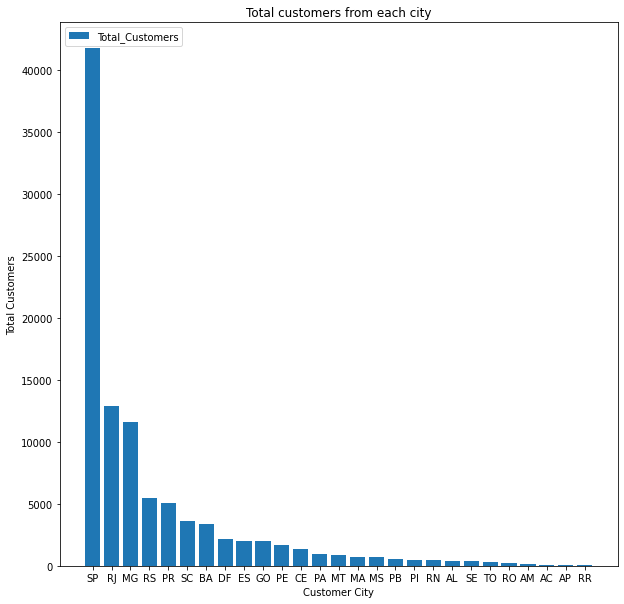

2022-02-11 06:53:11,840 - custom_log - INFO - Plotted Customers VS State


In [0]:
'''
Display total number of customers by regions
'''

try:
    import matplotlib.pyplot as plt

    plt_1 = plt.figure(figsize=(10, 10))
    y_Total_Customers = [val.Total_Customers for val in totalCustomers.select('Total_Customers').collect()]
    x_customer_state = [val.customer_state for val in totalCustomers.select('customer_state').collect()]
    plt.bar(x_customer_state,y_Total_Customers)
    plt.ylabel("Total Customers")
    plt.xlabel("Customer City")
    plt.title("Total customers from each city")
    plt.legend(['Total_Customers'], loc='upper left')
    plt.show()
    logger.info('Plotted Customers VS State')
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except ImportError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

In [0]:
'''
Find revenue generated annually
'''
try:
    annualRevenue = sqlContext.sql("select year(Orders.order_purchase_timestamp) as Year, sum(Order_Payments.payment_value) as Total_Revenue \
                                   from Order_Payments \
                                   full outer join Orders on Order_Payments.order_id = Orders.order_id \
                                   where Orders.order_status = 'delivered' \
                                   group by year(Orders.order_purchase_timestamp) \
                                   order by Year")
    display(annualRevenue)
    logger.info(annualRevenue)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:53:12,171 - custom_log - INFO - DataFrame[Year: int, Total_Revenue: double]


Year,Total_Revenue
2016,46586.329999999994
2017,6922571.410000065
2018,8451925.109999964


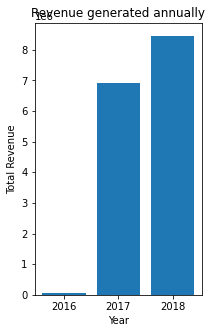

2022-02-11 06:53:24,536 - custom_log - INFO - Plotted Revenue vs Year


In [0]:
try:
    import matplotlib.pyplot as plt
    plt_1 = plt.figure(figsize=(3,5))
    x_year = [val.Year for val in annualRevenue.select('Year').collect()]
    y_total_revenue = [val.Total_Revenue for val in annualRevenue.select('Total_Revenue').collect()]
    plt.bar(x_year, y_total_revenue)
    plt.xlabel("Year")
    plt.ylabel("Total Revenue")
    plt.title("Revenue generated annually")
    plt.show()
    logger.info('Plotted Revenue vs Year')
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except ImportError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

In [0]:
'''
Find Most valued Customers and Salesman

Valuable customer is being identified by highest amount the order has been placed by customer

Valuable Salesman is being identified by highest number of sales he has done for the company
'''

try:
    valuedCustomers = sqlContext.sql("select Customers.customer_id as Most_Valuable_customer, Customers.customer_unique_id, Order_Payments.payment_value as Transaction_Amt \
                                     from Customers \
                                     join Orders on Customers.customer_id = Orders.customer_id \
                                     join Order_Payments on Order_Payments.order_id = Orders.order_id \
                                     where Order_Payments.payment_value = (select max(payment_value) from Order_Payments)")

    valuedSeller = sqlContext.sql("Select seller_id as Most_valuable_seller, count(seller_id) as Total_Sales \
                                  from Order_items \
                                  group by seller_id \
                                  order by Total_Sales desc")

    valuedCustomers.show(1)
    logger.info(valuedCustomers)
    valuedSeller.show(1)
    logger.info(valuedSeller)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:53:29,729 - custom_log - INFO - DataFrame[Most_Valuable_customer: string, customer_unique_id: string, Transaction_Amt: double]
+----------------------+--------------------+---------------+
|Most_Valuable_customer|  customer_unique_id|Transaction_Amt|
+----------------------+--------------------+---------------+
|  1617b1357756262bf...|0a0a92112bd4c708c...|       13664.08|
+----------------------+--------------------+---------------+

2022-02-11 06:53:31,755 - custom_log - INFO - DataFrame[Most_valuable_seller: string, Total_Sales: bigint]
+--------------------+-----------+
|Most_valuable_seller|Total_Sales|
+--------------------+-----------+
|6560211a19b47992c...|       2033|
+--------------------+-----------+
only showing top 1 row



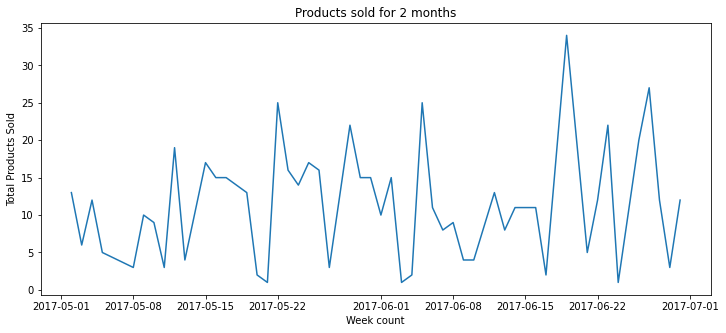

2022-02-11 06:53:41,740 - custom_log - INFO - <module 'matplotlib.pyplot' from '/databricks/python/lib/python3.8/site-packages/matplotlib/pyplot.py'>


In [0]:
'''
Product_Category sales over Time for Product Category informatica_acessorios over 2 months from 2017-05-01 to 2017-07-01
'''
try:
    import matplotlib.pyplot as plt

    plt_1 = plt.figure(figsize=(12,5))

    topProducts =  sqlContext.sql("select Product_Translation.product_category_name_english, count(Orders.order_id) as Total_Products_sold, \
                                  date(Orders.order_delivered_customer_date) as Date \
                                  from Orders \
                                  join Order_items on Order_items.order_id = Orders.order_id \
                                  join Products on Products.product_id = Order_items.product_id \
                                  join Product_Translation on Product_Translation.product_category_name = Products.product_category_name \
                               where Products.product_category_name = 'informatica_acessorios' and Orders.order_delivered_customer_date between '2017-05-01' and '2017-07-01'  \
                                  group by date(Orders.order_delivered_customer_date), Product_Translation.product_category_name_english order by Date")

    x_date = [val.Date for val in topProducts.select('Date').collect()]
    y_product_count = [val.Total_Products_sold for val in topProducts.select('Total_Products_sold').collect()]

    plt.plot(x_date, y_product_count)
    plt.xlabel("Week count")
    plt.ylabel("Total Products Sold")
    plt.title("Products sold for 2 months")

    plt.show()
    logger.info(plt)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except ImportError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

In [0]:
'''
Total Orders by city
'''

try:
    ordersByCity = sqlContext.sql("select Customers.customer_city as City, count(Orders.order_id) as Total_Orders \
                                  from Customers \
                                  full outer join Orders on Customers.customer_id = Orders.customer_id \
                                  group by Customers.customer_city \
                                  order by Total_Orders desc")
    display(ordersByCity)
    logger.info(ordersByCity)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:53:41,793 - custom_log - INFO - DataFrame[City: string, Total_Orders: bigint]


City,Total_Orders
sao paulo,15046
rio de janeiro,6604
belo horizonte,2697
brasilia,2071
curitiba,1489
campinas,1406
porto alegre,1341
salvador,1188
guarulhos,1143
sao bernardo do campo,911


In [0]:
'''
Most Reviewed product
'''

try:
    mostReviewedProduct = sqlContext.sql("select Order_items.product_id, Product_Translation.product_category_name_english as Product_Category, count(Reviews.order_id) as \
                                         Total_reviews \
                                         from Order_items join Reviews on Order_items.order_id = Reviews.order_id \
                                         join Products on Products.product_id = Order_items.product_id \
                                         join Product_Translation on Product_Translation.product_category_name = Products.product_category_name \
                                         where Order_items.product_id is not null \
                                         group by Order_items.product_id, Product_Translation.product_category_name_english \
                                         order by Total_reviews desc")
    mostReviewedProduct.show(1)
    logger.info(mostReviewedProduct)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:53:54,148 - custom_log - INFO - DataFrame[product_id: string, Product_Category: string, Total_reviews: bigint]
+--------------------+----------------+-------------+
|          product_id|Product_Category|Total_reviews|
+--------------------+----------------+-------------+
|aca2eb7d00ea1a7b8...| furniture_decor|          524|
+--------------------+----------------+-------------+
only showing top 1 row



In [0]:
'''
Find min and max priced products
'''

try:
    maxPrice = sqlContext.sql("select distinct Products.product_id as Maximum_Priced_Product_ID, Product_Translation.product_category_name_english as \
                              Maximum_Priced_Product_Name, \
                              Order_items.price \
                              from Order_items \
                              join Products on Products.product_id = Order_items.product_id \
                              join Product_Translation on Product_Translation.product_category_name = Products.product_category_name \
                              where Order_items.price = (select max(price) from Order_items)")

    minPrice = sqlContext.sql("select distinct Products.product_id as Minimum_Priced_Product_ID, Product_Translation.product_category_name_english as \
                               Minimum_Priced_Product_Name, \
                              Order_items.price \
                              from Order_items \
                              join Products on Products.product_id = Order_items.product_id \
                              join Product_Translation on Product_Translation.product_category_name = Products.product_category_name \
                              where Order_items.price = (select min(price) from Order_items)")

    display(maxPrice)
    logger.info(maxPrice)
    display(minPrice)
    logger.info(minPrice)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:53:54,277 - custom_log - INFO - DataFrame[Maximum_Priced_Product_ID: string, Maximum_Priced_Product_Name: string, price: double]
2022-02-11 06:53:54,282 - custom_log - INFO - DataFrame[Minimum_Priced_Product_ID: string, Minimum_Priced_Product_Name: string, price: double]


Maximum_Priced_Product_ID,Maximum_Priced_Product_Name,price
489ae2aa008f021502940f251d4cce7f,housewares,6735.0


Minimum_Priced_Product_ID,Minimum_Priced_Product_Name,price
8a3254bee785a526d548a81a9bc3c9be,construction_tools_construction,0.85


In [0]:
'''
Returning Customers to understand Customer loyalty

Loyalty of a customer is being identified by the total number of orders he/she placed

Displaying in output the top 20 customers
'''

try:
    customerLoyalty = sqlContext.sql("select Customers.customer_id as Most_Loyal_customer, count(Order_items.order_id) as Total_Order_Products \
                                     from Orders \
                                     join Order_items on Orders.order_id = Order_items.order_id \
                                     join Customers on Customers.customer_id = Orders.customer_id \
                                     group by Customers.customer_id \
                                     order by Total_Order_Products desc")
    logger.info(customerLoyalty)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)
finally:
    display(customerLoyalty)

2022-02-11 06:54:02,782 - custom_log - INFO - DataFrame[Most_Loyal_customer: string, Total_Order_Products: bigint]


Most_Loyal_customer,Total_Order_Products
fc3d1daec319d62d49bfb5e1f83123e9,21
bd5d39761aa56689a265d95d8d32b8be,20
be1b70680b9f9694d8c70f41fa3dc92b,20
10de381f8a8d23fff822753305f71cae,15
adb32467ecc74b53576d9d13a5a55891,15
d5f2b3f597c7ccafbb5cac0bcc3d6024,14
a7693fba2ff9583c78751f2b66ecab9d,14
7d321bd4e8ba1caf74c4c1aabd9ae524,13
91f92cfee46b79581b05aa974dd57ce5,12
daf15f1b940cc6a72ba558f093dc00dd,12


In [0]:
'''
Show how many orders have been placed by how many customers
'''

try:
    ordersPlacedByCustomers = sqlContext.sql("select count(Customers.customer_id) as Total_Customers, count(order_id) as Total_Orders \
                                             from Orders join Customers on Orders.customer_id = Customers.customer_id")
    display(ordersPlacedByCustomers)
    logger.info(ordersPlacedByCustomers)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:54:08,067 - custom_log - INFO - DataFrame[Total_Customers: bigint, Total_Orders: bigint]


Total_Customers,Total_Orders
96476,96476


In [0]:
'''
Show 80-20 analysis of products vs price

Finding Cummulative price and cummulative percentage for products being sold
'''

try:
    pareto_df = sqlContext.sql("select product_id, price from Order_items order by price desc")
    pareto_df.createOrReplaceTempView('Pareto')

    pareto_df1 = sqlContext.sql("select *, sum(price) \
                                over(order by price desc, product_id) as Cummulative_Price \
                                from Pareto")

    pareto_df1.createOrReplaceTempView('Pareto')
    finalCummulativePrice = sqlContext.sql("select Cummulative_Price \
                                           from Pareto \
                                           where Cummulative_Price = (select max(Cummulative_Price) from Pareto)").collect()

    pareto_df1 = pareto_df1.withColumn("Cummulative_Percentage", (col("Cummulative_Price")/finalCummulativePrice[0][0])*100)
    pareto_df1.createOrReplaceTempView('Pareto')
    display(pareto_df1)
    logger.info(pareto_df1)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 06:54:16,901 - custom_log - INFO - DataFrame[product_id: string, price: double, Cummulative_Price: double, Cummulative_Percentage: double]


product_id,price,Cummulative_Price,Cummulative_Percentage
489ae2aa008f021502940f251d4cce7f,6735.0,6735.0,0.04955250555891171
69c590f7ffc7bf8db97190b6cb6ed62e,6729.0,13464.0,0.09906086634672417
1bdf5e6731585cf01aa8169c7028d6ad,6499.0,19963.0,0.14687701090906527
a6492cc69376c469ab6f61d8f44de961,4799.0,24762.0,0.18218547032661797
c3ed642d592594bb648ff4a04cee2747,4690.0,29452.0,0.2166919664025342
259037a6a41845e455183f89c5035f18,4590.0,34042.0,0.2504627162934629
a1beef8f3992dbd4cd8726796aa69c53,4399.87,38441.87,0.28283459196287475
6cdf8fc1d741c76586d8b6b15e9eef30,4099.99,42541.86,0.31300011197274596
dd113cb02b2af9c8e5787e8f1f0722f6,4059.0,46600.86,0.3428640496213907
6902c1962dd19d540807d0ab8fade5c6,3999.9,50600.76,0.3722931612747079


<command-3943431398124483>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_product, rotation=90)
<Figure size 1440x720 with 0 Axes>

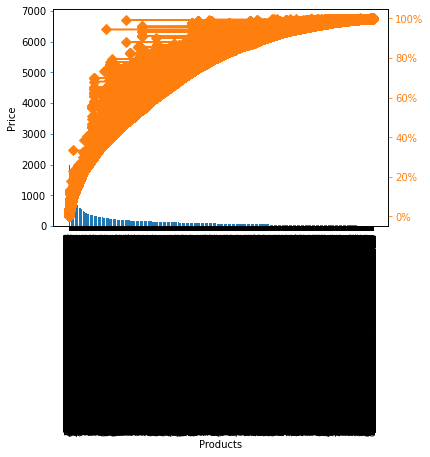

2022-02-11 07:14:14,810 - custom_log - INFO - Displayed Pareto (80-20 analysis) chart for Product over price


In [0]:
'''
Show 80-20 analysis of products vs price
'''

try:
    import matplotlib.pyplot as plt
    from matplotlib.ticker import PercentFormatter

    plt_1 = plt.figure(figsize=(20,10))

    fig, ax1 = plt.subplots()
    x_product = [val.product_id for val in pareto_df1.select('product_id').collect()]
    y_left_price = [val.price for val in pareto_df1.select('price').collect()]
    y_right_percentage = [val.Cummulative_Percentage for val in pareto_df1.select('Cummulative_Percentage').collect()]

    ax1.bar(x_product, y_left_price, color='C0')
    ax1.set_ylabel('Price')
    ax1.tick_params(axis="y",color="C0")
    ax1.set_xlabel('Products')
    ax1.set_xticklabels(x_product, rotation=90)

    ax2=ax1.twinx()
    ax2.plot(x_product, y_right_percentage, color="C1", marker="D", ms=7)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.tick_params(axis='y', colors="C1")

    plt.show()
    logger.info('Displayed Pareto (80-20 analysis) chart for Product over price')
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except ImportError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

<command-34057406250720>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_product, rotation=90)
<Figure size 1440x720 with 0 Axes>

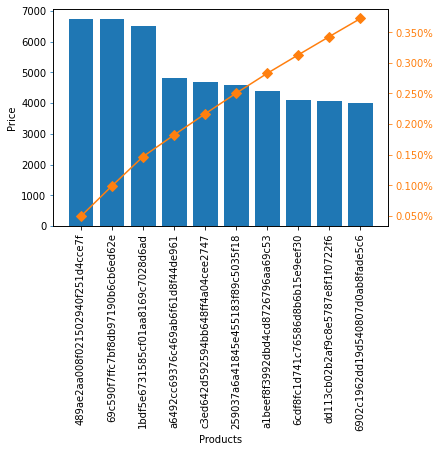

2022-02-11 07:14:20,978 - custom_log - INFO - <module 'matplotlib.pyplot' from '/databricks/python/lib/python3.8/site-packages/matplotlib/pyplot.py'>


product_id,price,Cummulative_Price,Cummulative_Percentage
489ae2aa008f021502940f251d4cce7f,6735.0,6735.0,0.04955250555891171
69c590f7ffc7bf8db97190b6cb6ed62e,6729.0,13464.0,0.09906086634672417
1bdf5e6731585cf01aa8169c7028d6ad,6499.0,19963.0,0.14687701090906527
a6492cc69376c469ab6f61d8f44de961,4799.0,24762.0,0.18218547032661797
c3ed642d592594bb648ff4a04cee2747,4690.0,29452.0,0.2166919664025342
259037a6a41845e455183f89c5035f18,4590.0,34042.0,0.2504627162934629
a1beef8f3992dbd4cd8726796aa69c53,4399.87,38441.87,0.28283459196287475
6cdf8fc1d741c76586d8b6b15e9eef30,4099.99,42541.86,0.31300011197274596
dd113cb02b2af9c8e5787e8f1f0722f6,4059.0,46600.86,0.3428640496213907
6902c1962dd19d540807d0ab8fade5c6,3999.9,50600.76,0.3722931612747079


In [0]:
'''
Show 80-20 analysis of products vs price
Sample first 10 rows
'''

try:
    import matplotlib.pyplot as plt
    from matplotlib.ticker import PercentFormatter
    import pandas as pd

    pareto_df_sample = pareto_df1.head(10)
    sample_Pareto = pd.DataFrame(pareto_df_sample)
    sample_Pareto.columns =['product_id', 'price', 'Cummulative_Price', 'Cummulative_Percentage']
    Sample_Pareto=spark.createDataFrame(sample_Pareto)
    display(Sample_Pareto)

    plt_1 = plt.figure(figsize=(20,10))

    fig, ax1 = plt.subplots()
    x_product = [val.product_id for val in Sample_Pareto.select('product_id').collect()]
    y_left_price = [val.price for val in Sample_Pareto.select('price').collect()]
    y_right_percentage = [val.Cummulative_Percentage for val in Sample_Pareto.select('Cummulative_Percentage').collect()]

    ax1.bar(x_product, y_left_price, color='C0')
    ax1.set_ylabel('Price')
    ax1.tick_params(axis="y",color="C0")
    ax1.set_xlabel('Products')
    ax1.set_xticklabels(x_product, rotation=90)

    ax2=ax1.twinx()
    ax2.plot(x_product, y_right_percentage, color="C1", marker="D", ms=7)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.tick_params(axis='y', colors="C1")

    plt.show()
    logger.info(plt)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except ImportError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

In [0]:
'''
Calculate shipment aging for each order
'''

try:
    dateDiff = sqlContext.sql("select order_id, DATEDIFF(order_delivered_customer_date, order_approved_at) as Days \
                              from Orders \
                              where order_delivered_customer_date is not null \
                              order by Days desc")

    display(dateDiff)
    logger.info(dateDiff)
except SyntaxError as ex:
    logger.error(ex)
except AttributeError as ex:
    logger.error(ex)
except Exception as ex:
    logger.error(ex)

2022-02-11 07:14:21,228 - custom_log - INFO - DataFrame[order_id: string, Days: int]


order_id,Days
ca07593549f1816d26a572e06dc1eab6,208
1b3190b2dfa9d789e1f14c05b647a14a,208
2fb597c2f772eca01b1f5c561bf6cc7b,195
285ab9426d6982034523a855f55a885e,195
0f4519c5f1c541ddec9f21b3bddd533a,194
440d0d17af552815d15a9e41abe49359,194
47b40429ed8cce3aee9199792275433f,191
2fe324febf907e3ea3f2aa9650869fa5,190
2d7561026d542c8dbd8f0daeadf67a43,188
c27815f7e3dd0b926b58552628481575,188


In [0]:
'''
Transferring LOG file from tmp directory to FileStore of databricks
'''

dbutils.fs.mv("file:"+logfile, "dbfs:/FileStore/Logging/"+filename)
dbutils.fs.ls('/FileStore/Logging')
filepath = 'dbfs:/FileStore/Logging/'+filename
file = spark.read.text(filepath)
display(file)

value
"2022-02-11 06:52:34,495 - custom_log - INFO - =========Start INFO Logger Here ========"
"2022-02-11 06:52:34,498 - custom_log - DEBUG - =========Start DEBUG Logger Here ========"
"2022-02-11 06:52:34,500 - custom_log - ERROR - =========Start ERROR Logger Here ========"
"2022-02-11 06:52:34,502 - custom_log - WARNING - =========Start Warning Logger Here ========"
"2022-02-11 06:52:34,505 - custom_log - CRITICAL - =========Start Critical Logger Here ========"
"2022-02-11 06:52:45,160 - custom_log - INFO - Successfully loaded the files into Storage"
"2022-02-11 06:52:46,280 - custom_log - INFO - DataFrame[product_id: string, product_category_name_english: string]"
"2022-02-11 06:52:55,663 - custom_log - INFO - DataFrame[Total_Revenue: double]"
"2022-02-11 06:53:00,335 - custom_log - INFO - DataFrame[product_category_name_english: string, Total_Orders: bigint]"
"2022-02-11 06:53:04,868 - custom_log - INFO - DataFrame[customer_state: string, Total_Customers: bigint]"


In [0]:
'''
Shutdown Logging
'''

logging.shutdown()